# Image model training
## Imports

In [85]:
from image_model_training import *
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf

## Parámetros
Se establecen los parámetros para el entrenamiento.

In [86]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"

data_origin = EXT
model_type = MICRO
epochs = 10


if data_origin == MICRO:
    data_dir = f"{project_dir}/samples/microcontroller/preprocessed image"
    augment = True
else:
    data_dir = f"{project_dir}/samples/external/preprocessed image"
    augment = False

## Carga de datos
Se generan datasets de entrenamiento, validación y test a partir de las imágenes recolectadas.

In [87]:
train_dataset = image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=SEED,
                                             image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode="grayscale")

validation_dataset = image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=SEED,
                                                  image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode="grayscale")

class_names = train_dataset.class_names

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


Aplicamos o no data augmentation que consiste en aplicar pequeñas rotaciones, zoom o hacer flips horizontales de la
imagen.

In [88]:
if augment:
    train_dataset = augment_data(train_dataset)
    validation_dataset = augment_data(validation_dataset)

Comprobamos el contenido de los datasets. Primero listamos las classes y luego mostramos una pequeña muestra del
conjunto training.

Classes:
	0: face
	1: mask
	2: nothing


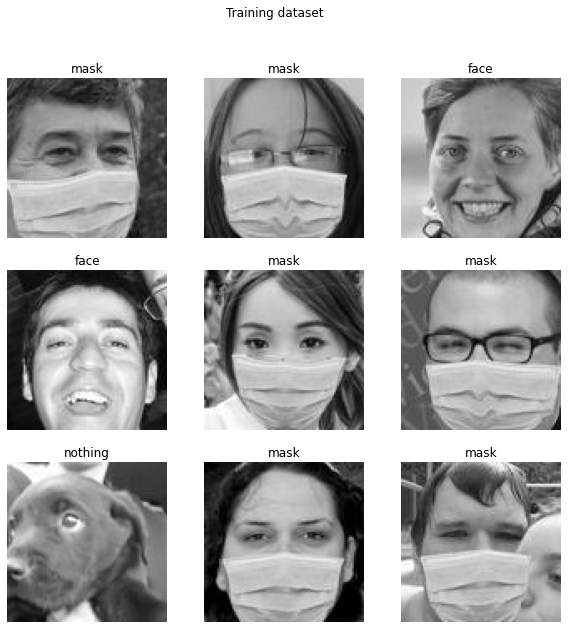

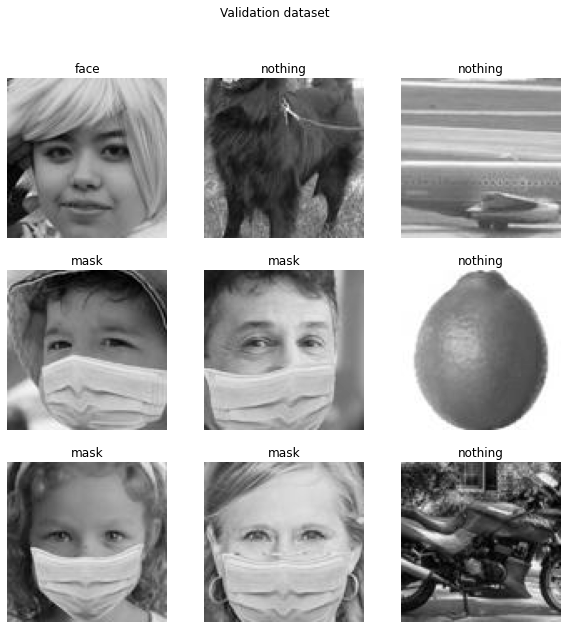

In [89]:
print("Classes:")
for index, name in enumerate(class_names):
    print(f"\t{index}: {name}")

fig, _ = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(10, 10)
fig.suptitle("Training dataset")
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = fig.axes[i]
        ax.imshow(images[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        ax.set_title(class_names[labels[i]])
        ax.axis("off")

fig, _ = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(10, 10)
fig.suptitle("Validation dataset")
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = fig.axes[i]
        ax.imshow(images[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        ax.set_title(class_names[labels[i]])
        ax.axis("off")

Ajustamos la configuración de los datasets para entrenamiento.

In [90]:
train_dataset = train_dataset.cache().shuffle(1000, seed=SEED).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Normalizamos el dataset para que los datos tengan valores en [-1, 1] que funcionan mejor para entrenar el modelo.py

In [91]:
train_dataset = normalize_dataset(train_dataset, negative=False)
validation_dataset = normalize_dataset(validation_dataset, negative=False)

## Creación del modelo

In [92]:
mobilenet = tf.keras.applications.MobileNet(input_shape=(96, 96, 1), include_top=False, weights=None, alpha=0.25)

num_classes = len(class_names)

model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=IMG_SHAPE),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "mobilenet_0.25_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 8)         72        
_________________________________________________________________
conv1_bn (BatchNormalization (None, 48, 48, 8)         32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 48, 48, 8)         0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 8)         72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 48, 48, 8)         32        
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 48, 48, 8)   

## Entrenamiento del modelo

In [93]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
375/375 [==============================] - 23s 55ms/step - loss: 0.3735 - accuracy: 0.8419 - val_loss: 0.0430 - val_accuracy: 0.9847

## Visualización de historial de entrenamiento

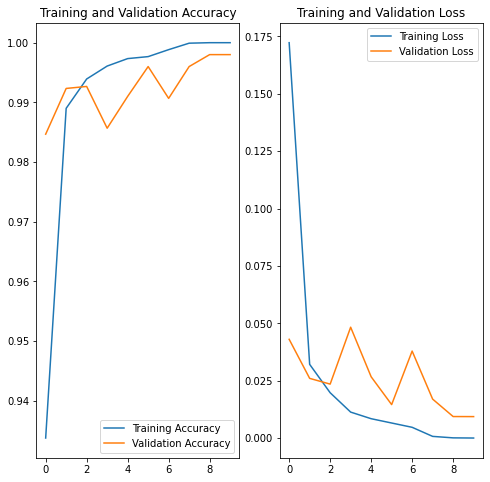

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

